# Importing stop words

In [1]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

# Prepare vague words list

In [2]:
from nltk.corpus import wordnet

In [3]:
def get_synonyms(ofword):
  from nltk.corpus import wordnet
  synonyms = []

  for syn in wordnet.synsets(ofword):
    for l in syn.lemmas():
      synonyms.append(l.name())

  return synonyms

In [4]:
def get_antonyms(ofword):
  from nltk.corpus import wordnet
  antonyms = []

  for syn in wordnet.synsets(ofword):
    for l in syn.lemmas():
      if l.antonyms():
          antonyms.append(l.antonyms()[0].name())

  return antonyms
  # print(set(antonyms))

In [5]:
synonyms = get_synonyms("active")
print (synonyms)

['active_agent', 'active', 'active_voice', 'active', 'active', 'active', 'active', 'combat-ready', 'fighting', 'active', 'active', 'participating', 'active', 'active', 'active', 'active', 'alive', 'active', 'active', 'active', 'dynamic', 'active', 'active', 'active']


In [6]:
# read the words to list
with open('vagueWords.txt') as vague_word_list_file:
    vague_word_list = vague_word_list_file.read().splitlines()

vague_word_set = set()

# Add the synonyms of each word
for vagueword in vague_word_list:
  for vague_word_synonym in get_synonyms(vagueword):
    vague_word_set.add(vague_word_synonym.lower())

# Add the antonyms( of each word 
for vagueword in vague_word_list:
  for vague_word_synonym in get_antonyms(vagueword):
    vague_word_set.add(vague_word_synonym.lower())

# Remove unncessary words
remove_word_list = ['adept']
for word in remove_word_list:
  if word in vague_word_set:
    vague_word_set.remove(word)

# Add words without adding synonyms
addtional_word_list = ['didnt', 'doesnt']
for word in addtional_word_list:
  vague_word_set.add(word)

vague_word_set = sorted(vague_word_set)

vague_word_list = list(vague_word_set)

print("No. of Vague words", len(vague_word_list))

No. of Vague words 357


# Importing the libraries

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import json
import math
import re # We clean text using regex
import csv # To read the csv
from collections import defaultdict # For accumlating values
from nltk.corpus import stopwords # To remove stopwords
from gensim import corpora # To create corpus and dictionary for the LDA model
from gensim.models import LdaModel # To use the LDA model
import pyLDAvis.gensim # To visualise LDA model effectively
import matplotlib.colors as mcolors
from collections import Counter

# Start with loading all necessary libraries
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# % matplotlib inline

In [8]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning) 

/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Importing the reviews

In [9]:
reviews = []
with open('reviews.json') as file:
  for line in file:
      entry = json.loads(line)
      reviews.append(entry["_source"]["review"])
print("Total No. of reviews =", len(reviews))

Total No. of reviews = 140590


# Small part of the reviews for fast testing

In [10]:
reviews = reviews[:1405] 

# Reviews Statistics

In [11]:
review_lengths = []
average_review_length = 0
total_length = 0
min_length = len(reviews[0])
max_length = 0
for i, review in enumerate(reviews):
  review_length = len(review)
  total_length = total_length + review_length
  review_lengths.append(review_length)
  if max_length < review_length:
    max_length = review_length
  if min_length > review_length:
    min_length = review_length

average_review_length = math.ceil(total_length/len(reviews))
print("Total Reviews: "+str(len(reviews))+ ", Average Review Length:"+ str(average_review_length)+", Minimum Length: "+str(min_length)+", Maximum Length: "+str(max_length))

Total Reviews: 1405, Average Review Length:372, Minimum Length: 3, Maximum Length: 6436


# Tokenize sentences

In [12]:
from nltk.tokenize import sent_tokenize

In [13]:
sentences_set = set()
for review in reviews:
  for sentence in sent_tokenize(review):
    sentences_set.add(sentence.lower())
sentences = list(sentences_set) 

#  Cleaning up the data

In [14]:
def get_stopwords():
  nltk.download('stopwords')
  from nltk.corpus import stopwords
  stopwords = set(stopwords.words('english'))
  # read the words to list
  with open('stopwords.txt') as stop_word_list_file:
    for word in stop_word_list_file.read().splitlines():
      stopwords.add(word.lower())

  additional_words = ["hi", "ok", "am", "would", "i'm","im","ill","cant","else","youd","otherwise","due"
  ,"youre","ive","havent","hasnt","hadnt","didnt","could","doesnt","may","wouldnt","dont","cant","could"
  ,"every","anyone","say","isnt","arent","also","cannot","itll","lets","youll","aspacingtopmini","hello"
  ,"theres","itthe","shes","hes","another","etc"]

  for word in additional_words:
    stopwords.add(word)
  return stopwords

In [15]:
reviews = sentences
reviews = [re.sub(r'[^\w\s]','',str(item)) for item in reviews]
stopwords = get_stopwords()
texts = [[word for word in document.lower().split() if word not in stopwords] for document in reviews]
frequency = defaultdict(int)
for text in texts:
    for token in text:
         frequency[token] += 1

texts = [[token for token in text if frequency[token] > 1] for text in texts]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data Processing

In [16]:
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# LDA

In [17]:
NUM_TOPICS = 12
ldamodel = LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, random_state=10, passes=15, alpha=0.01, eta=0.001)
topics = ldamodel.show_topics(num_topics= NUM_TOPICS,num_words=20,formatted=False)

# Ranking

In [18]:
def sum_of_probability_of_words_in_topic(topic_index, topics):
  sum = 0
  for index, value in enumerate(topics[topic_index][1]):
    sum += value[1]
    # print(value)
  return sum

def sum_of_probability_of_vague_words_in_topic(vague_word_list, topic_index, topics):
  sum = 0
  for index, value in enumerate(topics[topic_index][1]):
    if value[0] in vague_word_list:
      sum += value[1]
      # print(value)
  return sum  

def vagueness_degree(vague_word_list):
  for i in range(len(topics)):
    all_word_probability = sum_of_probability_of_words_in_topic(i, topics)
    vague_word_probability = sum_of_probability_of_vague_words_in_topic(vague_word_list, i, topics)
    percentage = round(vague_word_probability / all_word_probability * 100, 2)
    percentage_str = "percentage: " + str(percentage) + "%"
    if percentage >= 10.00:
      print("topic", f'{i+1:<2}', f'{"vague: " + str(round(vague_word_probability, 4)):<15}', f'{"probability sum: " + str(round(all_word_probability, 4)):<25}', f'{percentage_str:<20}', "vague")
    else:
      print("topic", f'{i+1:<2}', f'{"vague: " + str(round(vague_word_probability, 4)):<15}', f'{"probability sum: " + str(round(all_word_probability, 4)):<25}', f'{percentage_str:<20}')

    

vagueness_degree(vague_word_list)


topic 1  vague: 0.058    probability sum: 0.2972   percentage: 19.5%    vague
topic 2  vague: 0.0103   probability sum: 0.3387   percentage: 3.03%   
topic 3  vague: 0.0966   probability sum: 0.3794   percentage: 25.46%   vague
topic 4  vague: 0.0169   probability sum: 0.312    percentage: 5.4%    
topic 5  vague: 0.0391   probability sum: 0.3302   percentage: 11.83%   vague
topic 6  vague: 0.0077   probability sum: 0.2196   percentage: 3.5%    
topic 7  vague: 0.0509   probability sum: 0.4536   percentage: 11.21%   vague
topic 8  vague: 0.0097   probability sum: 0.2797   percentage: 3.46%   
topic 9  vague: 0.0135   probability sum: 0.414    percentage: 3.25%   
topic 10 vague: 0.0142   probability sum: 0.2944   percentage: 4.81%   
topic 11 vague: 0.032    probability sum: 0.2983   percentage: 10.71%   vague
topic 12 vague: 0        probability sum: 0.2137   percentage: 0.0%    


In [19]:
def print_vague_topic_words(vague_word_list):
  for i in range(len(topics)):
    all_word_probability = sum_of_probability_of_words_in_topic(i, topics)
    vague_word_probability = sum_of_probability_of_vague_words_in_topic(vague_word_list, i, topics)
    percentage = round(vague_word_probability / all_word_probability * 10000) / 100
    if percentage >= 10.00:
      print("\ntopic", i+1)
      for index, value in enumerate(topics[i][1]):
        print("             " + f'{value[0]:<14}', value[1])
print_vague_topic_words(vague_word_list)


topic 1
             usb            0.034761626
             drive          0.030402727
             fast           0.027783144
             hard           0.017181508
             port           0.017176406
             need           0.016188752
             card           0.015609468
             ssd            0.014982808
             bad            0.013257037
             going          0.011858849
             storage        0.011451751
             use            0.011408825
             memory         0.010272161
             one            0.010214753
             super          0.010097061
             external       0.010096085
             ports          0.009103029
             pretty         0.0088949045
             device         0.008449218
             enough         0.008028884

topic 3
             laptop         0.08292307
             good           0.04781814
             gaming         0.021805104
             better         0.02101954
             price      

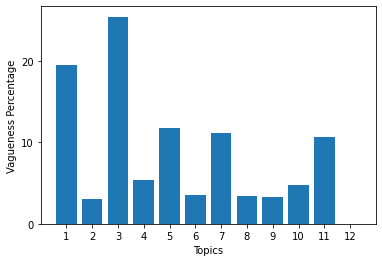

In [20]:
def plot_topic_percentage(topics):

  topic_rankings_x = []
  topic_rankings_y = []
  for i in range(len(topics)):
    all_word_count = sum_of_probability_of_words_in_topic(i, topics)
    vague_word_count = sum_of_probability_of_vague_words_in_topic(vague_word_list, i, topics)
    percentage = round(vague_word_count / all_word_count * 100, 2)
    topic_rankings_x.append(i + 1)
    topic_rankings_y.append(percentage)
    # print(percentage)

  plt.yticks(np.arange(0, 100, 10))
  plt.xticks(np.arange(1, NUM_TOPICS + 1, 1))
  plt.bar(topic_rankings_x, topic_rankings_y)
  plt.ylabel('Vagueness Percentage')
  plt.xlabel('Topics')
  plt.show()
plot_topic_percentage(topics)

# Word cloud

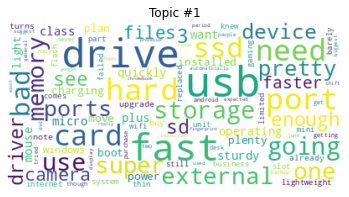

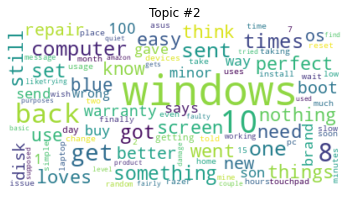

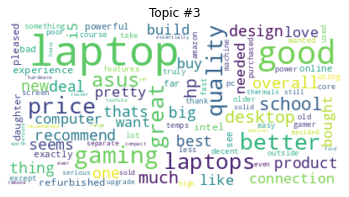

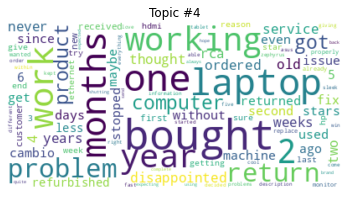

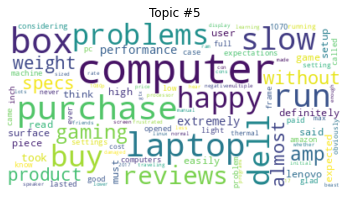

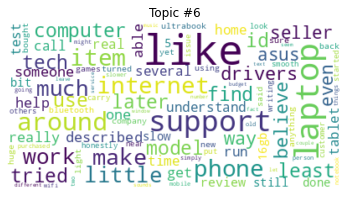

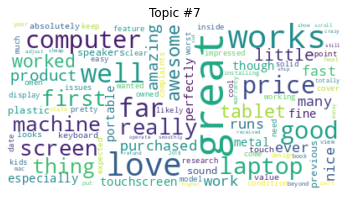

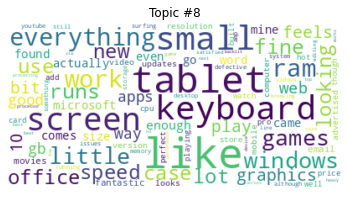

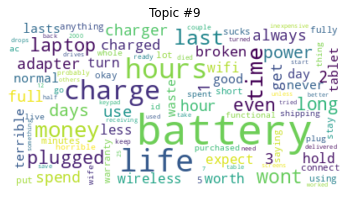

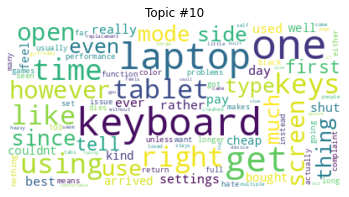

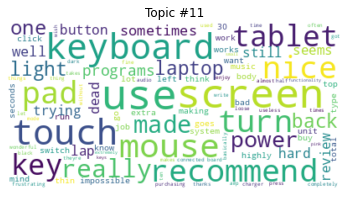

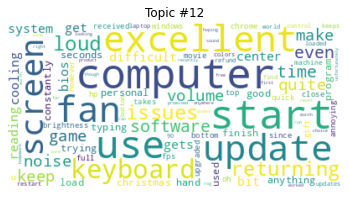

In [21]:
import matplotlib.pyplot as plt
for t in range(ldamodel.num_topics):
    plt.figure()
    plt.imshow(WordCloud(max_font_size=50, max_words=100, background_color="white").fit_words(dict(ldamodel.show_topic(t, 200))),interpolation="bilinear")
    plt.axis("off")
    plt.title("Topic #" + str(t+1))
    plt.show()


# Bar plot for top 20 words weights in each topic 

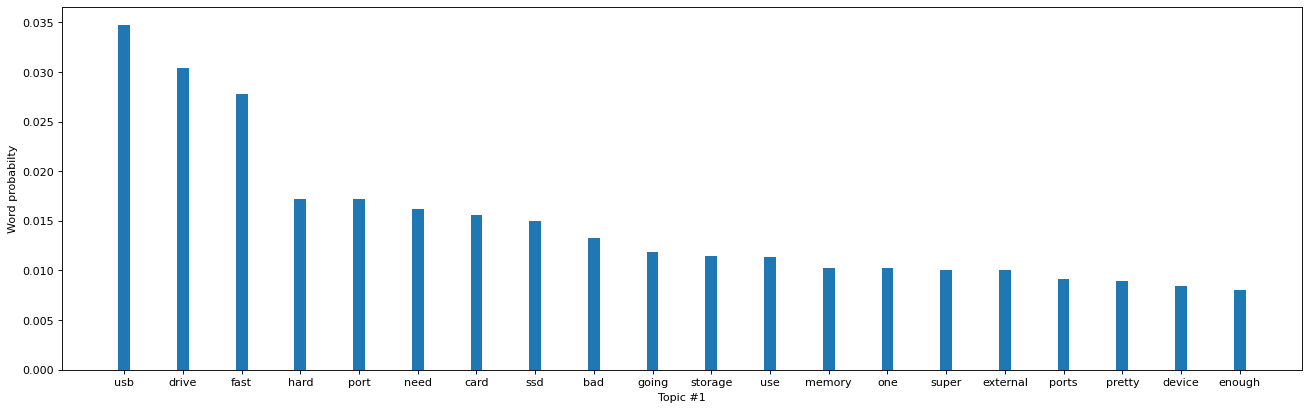

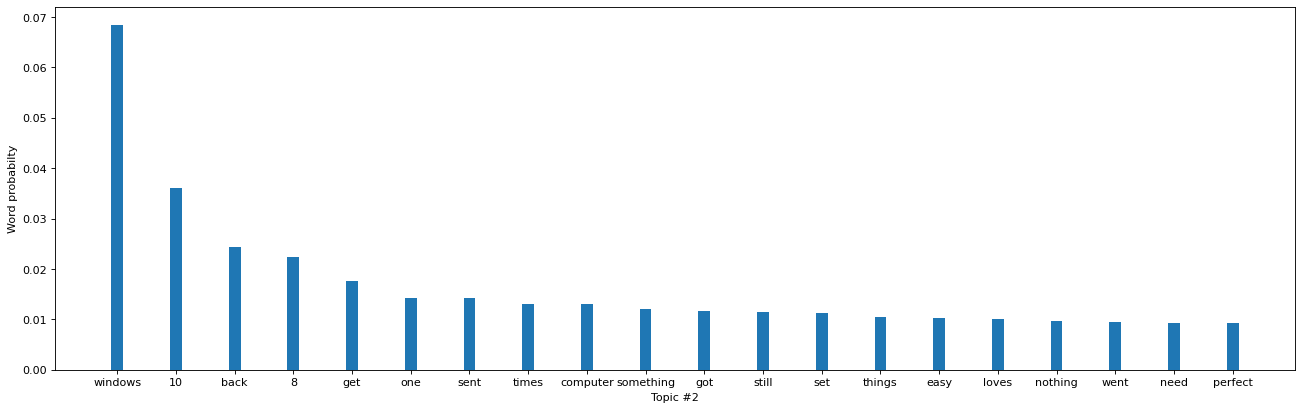

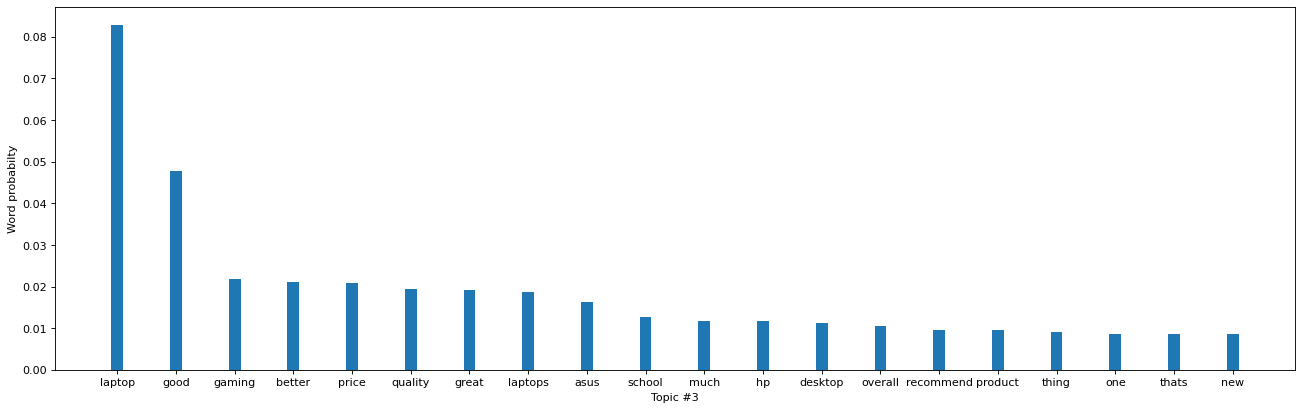

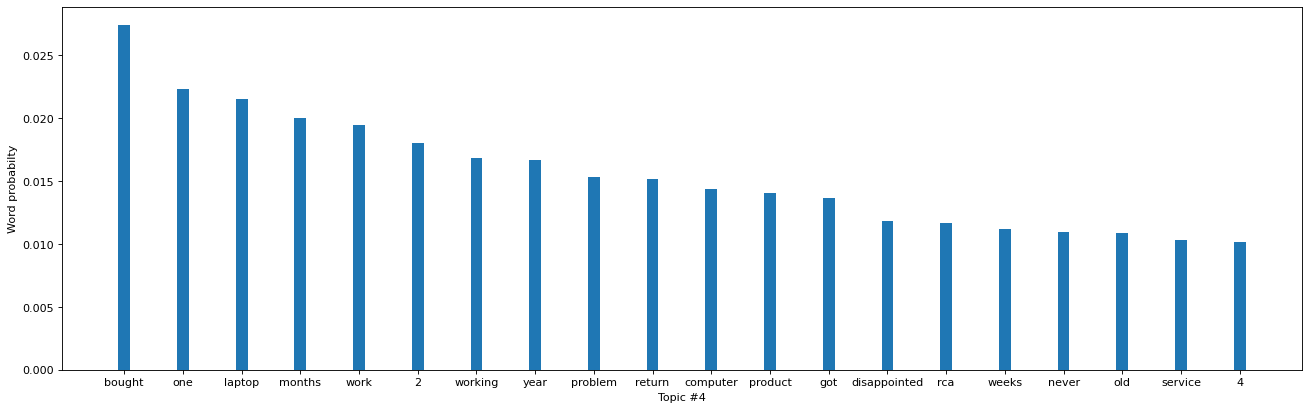

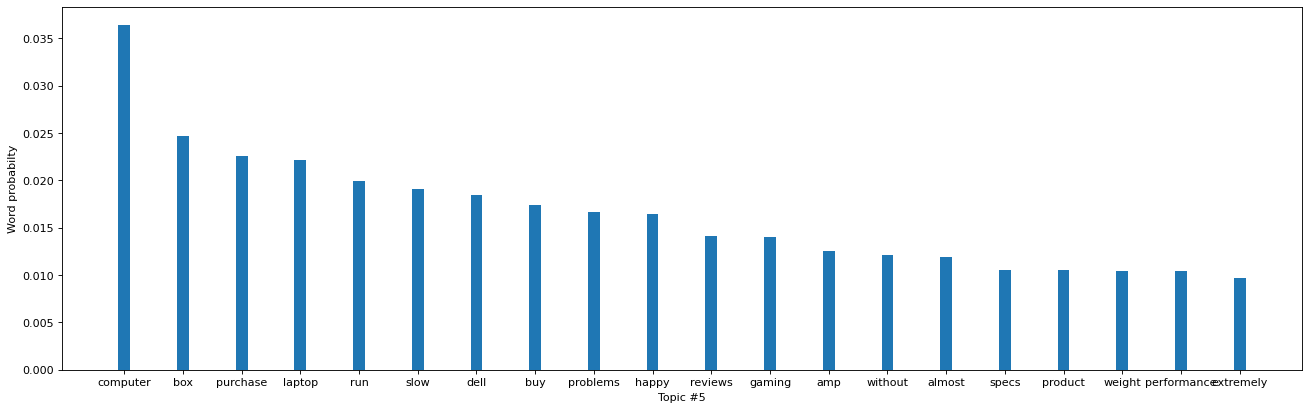

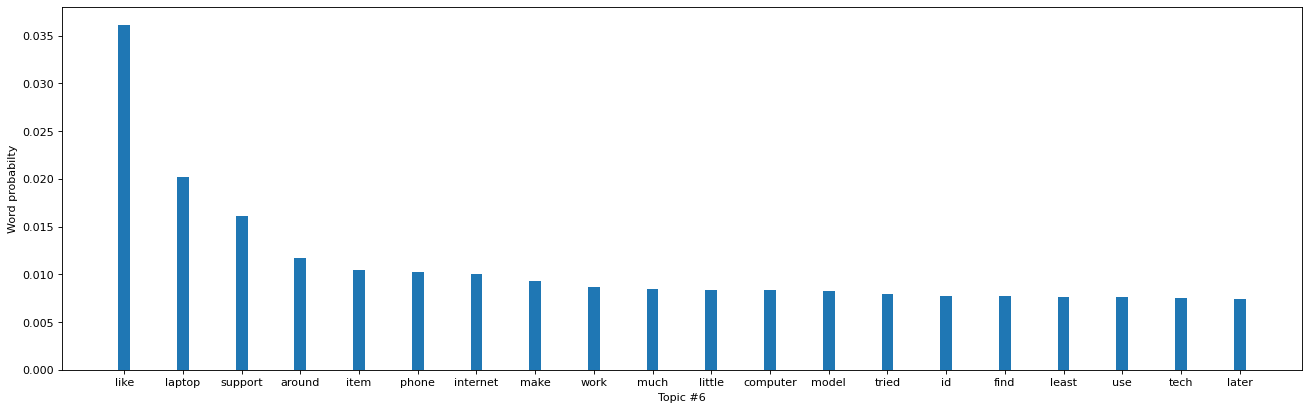

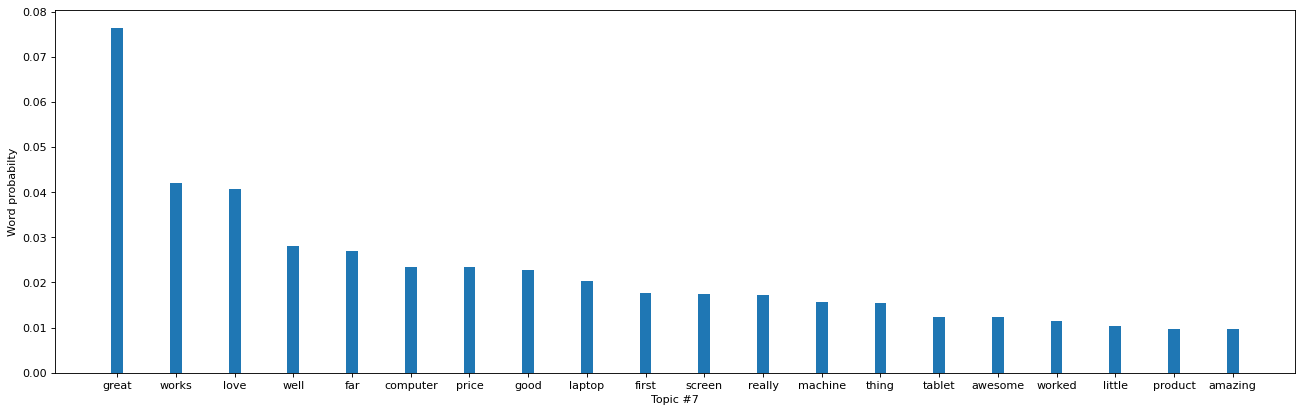

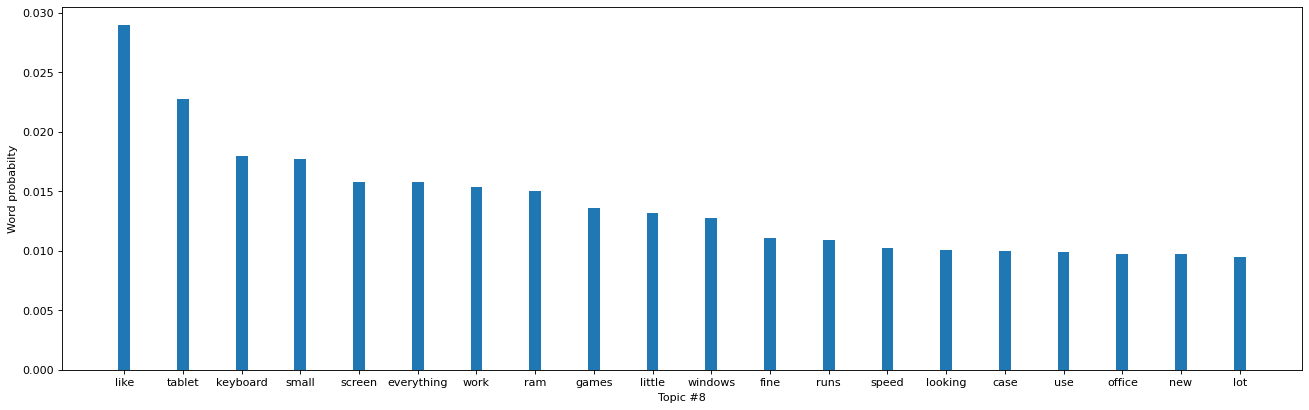

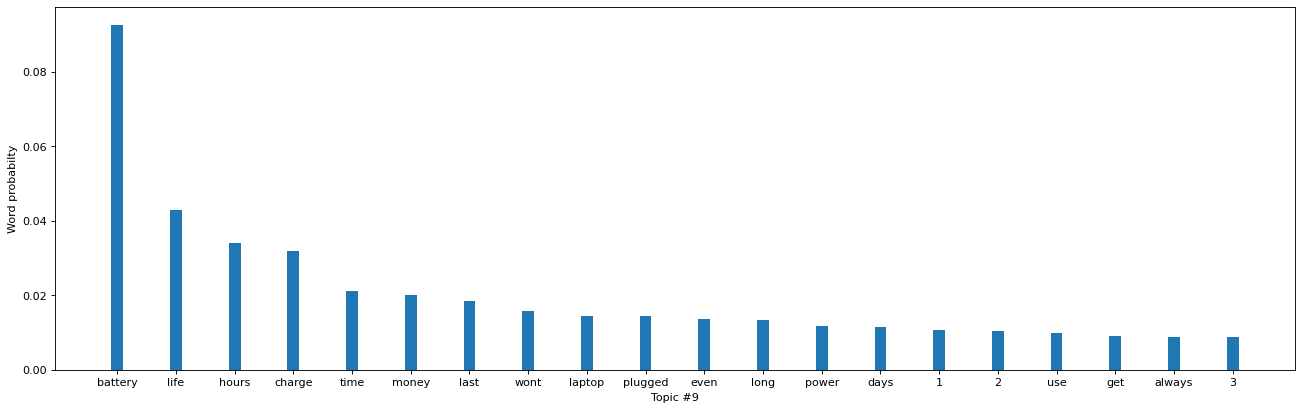

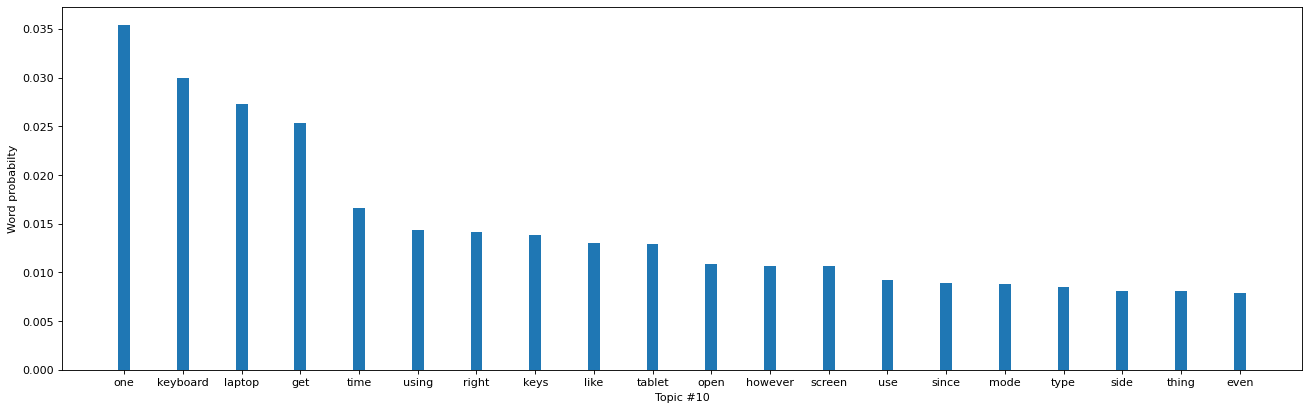

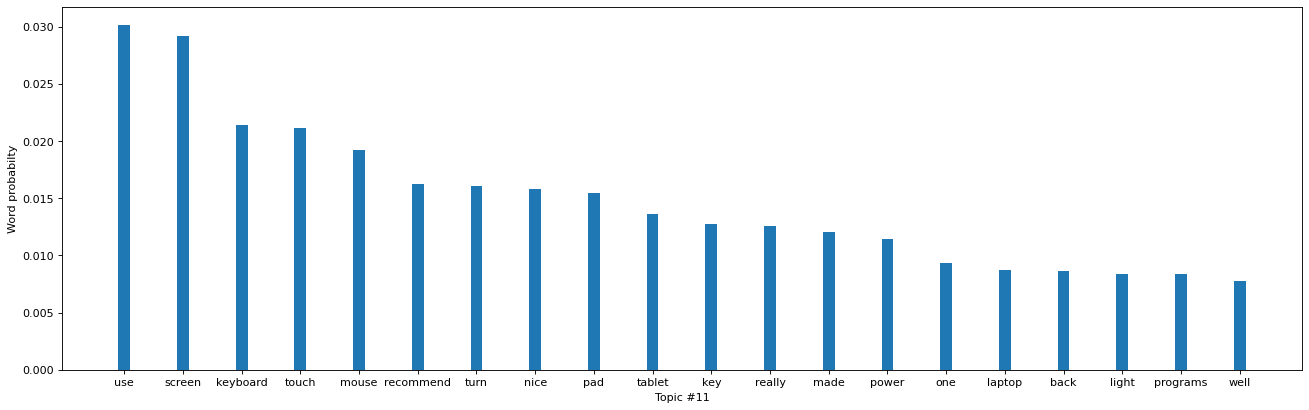

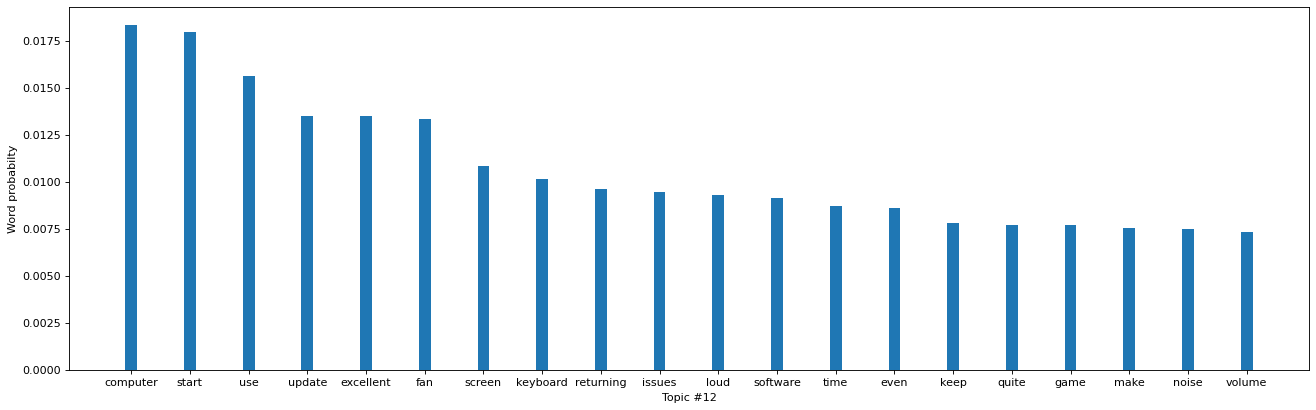

In [22]:
from matplotlib.pyplot import figure

def plot_words_in_topic(topics):
  for i in range(len(topics)):
    figure(figsize=(20, 6), dpi=80)
    y_ticks = []
    x_labels = []
    # print(topics[i][1])
    for key, value in enumerate(topics[i][1]):
      # print(value)
      y_ticks.append(value[1])
      x_labels.append(value[0])
    # plt.yticks(np.arange(0, 1, .1))
    x_ticks = list(range(1, (len(x_labels) + 1)))
    plt.xticks(x_ticks, x_labels)
    plt.bar(x_ticks, y_ticks, width=.2)
    plt.ylabel('Word probabilty')
    plt.xlabel('Topic #' + str(i + 1))
    plt.show()
    print()
    print()
plot_words_in_topic(topics)

# Top 20 Words in each topic 

In [23]:
word_dict = {};
for i in range(NUM_TOPICS):
    words = ldamodel.show_topic(i, topn = 20)
    word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words]
pd.DataFrame(word_dict)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10,Topic # 11,Topic # 12
0,usb,windows,laptop,bought,computer,like,great,like,battery,one,use,computer
1,drive,10,good,one,box,laptop,works,tablet,life,keyboard,screen,start
2,fast,back,gaming,laptop,purchase,support,love,keyboard,hours,laptop,keyboard,use
3,hard,8,better,months,laptop,around,well,small,charge,get,touch,update
4,port,get,price,work,run,item,far,screen,time,time,mouse,excellent
5,need,one,quality,2,slow,phone,computer,everything,money,using,recommend,fan
6,card,sent,great,working,dell,internet,price,work,last,right,turn,screen
7,ssd,times,laptops,year,buy,make,good,ram,wont,keys,nice,keyboard
8,bad,computer,asus,problem,problems,work,laptop,games,laptop,like,pad,returning
9,going,something,school,return,happy,much,first,little,plugged,tablet,tablet,issues


# Visualization

In [24]:
lda_display = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

# Hyperparameters Tuning 

## Optimum number of topics

Downloading LDA mallet

In [25]:
import gensim
import gensim.models
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    mallet_path = '/static/mallet-2.0.8/bin/mallet' # use it on google colab
    print('before running ', start, ' ', limit, ' ', step)
    for num_topics in range(start, limit, step):
        print('running')
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, random_seed=10, iterations=1, id2word=ldamodel.id2word)
        model_list.append(model)
        coherencemodel = gensim.models.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [26]:
start=9; limit=20; step=1;
#model_list, coherence_values = compute_coherence_values(dictionary=ldamodel.id2word, corpus=corpus, texts=texts, start=start, limit=limit, step=step)
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=texts, start=start, limit=limit, step=step)
# Show graph

before running  9   20   1
running
running
running
running
running
running
running
running
running
running
running


In [27]:
coherence_values

[0.15256654357803312,
 0.13513712355799404,
 0.1442795679073457,
 0.14149438562943484,
 0.15533388714996624,
 0.17666467856553797,
 0.17170708948523827,
 0.18316538163267168,
 0.1964098811417746,
 0.19283591964512353,
 0.20408949518298006]

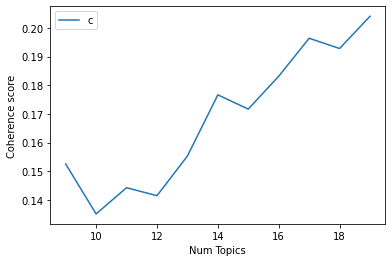

In [28]:
# Show graph
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [29]:
# Print the coherence scores
best_topic_no = 0
best_topic_cv = 0

for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
    if cv > best_topic_cv + 0.005:
        best_topic_cv = cv
        best_topic_no = m
print('Best coherence topic ', best_topic_no)

Num Topics = 9  has Coherence Value of 0.1526
Num Topics = 10  has Coherence Value of 0.1351
Num Topics = 11  has Coherence Value of 0.1443
Num Topics = 12  has Coherence Value of 0.1415
Num Topics = 13  has Coherence Value of 0.1553
Num Topics = 14  has Coherence Value of 0.1767
Num Topics = 15  has Coherence Value of 0.1717
Num Topics = 16  has Coherence Value of 0.1832
Num Topics = 17  has Coherence Value of 0.1964
Num Topics = 18  has Coherence Value of 0.1928
Num Topics = 19  has Coherence Value of 0.2041
Best coherence topic  19


Optimum values of Alpha and Eta

In [30]:
# supporting function to find alpha and beta
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    print("lda_model = gensim.models.LdaMulticore(corpus=corpus,")
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           workers=4,
                                           num_topics=k, 
                                           random_state=10,
                                           passes=10,
                                           alpha=a,
                                               eta=b)
    print("coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=texts, dictionary=ldamodel.id2word, coherence='c_v')")
    coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    
    print("return coherence_model_lda.get_coherence()")
    return coherence_model_lda.get_coherence()

In [31]:
import numpy as np

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = best_topic_no
max_topics = min_topics + 1
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.5))
#alpha.append('symmetric')
#alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.5))
#beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               # gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]
            
corpus_title = [#'25% Corpus',
                #'50% Corpus',
                 '75% Corpus',
                '100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
                
# Can take a long time to run
if 1 == 1:
    #pbar = tqdm.tqdm(total=540)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        print("i " + str(i))
        # iterate through number of topics
        for k in topics_range:
            print("k "  + str(k))
            # iterate through alpha values
            for a in alpha:
                print("a " + str(a))
                # iterare through beta values
                for b in beta:
                    print("b " + str(b))
                    print("# get the coherence score for the given parameters")
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dictionary, k=k, a=a, b=b)
                    print("# Save the model results")
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
 #                   pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
  #  pbar.close()

i 0
k 19
a 0.01
b 0.01
# get the coherence score for the given parameters
lda_model = gensim.models.LdaMulticore(corpus=corpus,
coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=texts, dictionary=ldamodel.id2word, coherence='c_v')
return coherence_model_lda.get_coherence()
# Save the model results
b 0.51
# get the coherence score for the given parameters
lda_model = gensim.models.LdaMulticore(corpus=corpus,
coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=texts, dictionary=ldamodel.id2word, coherence='c_v')
return coherence_model_lda.get_coherence()
# Save the model results
a 0.51
b 0.01
# get the coherence score for the given parameters
lda_model = gensim.models.LdaMulticore(corpus=corpus,
coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=texts, dictionary=ldamodel.id2word, coherence='c_v')
return coherence_model_lda.get_coherence()
# Save the model results
b 0.51
# get the coherence score for the given parameter

In [32]:
pd.set_option('display.max_rows', 400)
model_results_df = pd.DataFrame(model_results).sort_values(by=['Coherence'], ascending=[False]).reset_index(drop=True)
model_results_df

,Validation_Set,Topics,Alpha,Beta,Coherence
0,75% Corpus,19,0.51,0.01,0.313000
1,75% Corpus,19,0.51,0.51,0.307192
2,75% Corpus,19,0.01,0.51,0.297887
3,75% Corpus,19,0.01,0.01,0.287199


In [33]:
print("The recommended nubmer of topics is", model_results_df['Topics'][0], "with value of Alpha=", model_results_df['Alpha'][0], "and Eta=", model_results_df['Beta'][0])

The recommended nubmer of topics is 19 with value of Alpha= 0.51 and Eta= 0.01


In [34]:
!pip freeze > requirements.txt